In [1]:
!pip install transformers

In [2]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [3]:
# imports
import numpy as np
import pandas as pd

# set pandas to display the maximum range if necessary
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_json (r'/content/drive/MyDrive/Colab Notebooks/emotion_data/unified-dataset.json', lines=True)
set(df['source'])

{'affectivetext',
 'crowdflower',
 'dailydialogues',
 'electoraltweets',
 'emoint',
 'emotion-cause',
 'emotiondata-aman',
 'fb-valence-arousal-anon',
 'grounded_emotions',
 'isear',
 'ssec',
 'tales-emotion',
 'tec'}

In [4]:
print(len(df.loc[df['source'] == 'tales-emotion']))
df_tales = df.loc[df['source'] == 'tales-emotion']
df_tales[:1]

14771


,id,VAD,source,text,emotions,split,emotion_model,annotation_procedure,domain,labeled,optional
200696,200696,"{'valence': None, 'arousal': None, 'dominance': None}",tales-emotion,What a funny sight it is to see a brood of ducklings with a hen!,"{'joy': 0, 'anger': 0, 'sadness': 0, 'disgust': 0, 'fear': 0, 'trust': None, 'surprise': 0, 'love': None, 'noemo': 1, 'confusion': None, 'anticipation': None, 'shame': None, 'guilt': None}",NaN,Ekman,NaN,fairytale_sentences,single,{'_tales_source': 'the_tale_of_jemima_puddle-duck.emmood'}


In [5]:
emotions = df_tales['emotions']
target_emotions = []
for index in emotions:
    foo = {k: index[k] for k in index.keys() & {'joy', 'anger', 'sadness', 'disgust','fear'}}
    # foo = {k: index[k] for k in index.keys()}
    if all(value == 0 for value in foo.values()):
        foo = 'None'
    else:
        foo = list(foo.keys())[list(foo.values()).index(1)]
    target_emotions.append(foo)
df_tales['target_emotions']= pd.Series(target_emotions).values
df_tales = df_tales.drop(['id', 'VAD', 'source', 'emotions', 'split', 'emotion_model', 'annotation_procedure', 'domain', 'labeled', 'optional'], axis=1)
df_tales[:2]

,text,target_emotions
200696,What a funny sight it is to see a brood of ducklings with a hen!,None
200697,"Listen to the story of Jemima Puddle-duck, who was annoyed because the farmer's wife would not let her hatch her own eggs.",anger


In [6]:
indexNames = df_tales[df_tales['target_emotions'] == 'None'].index
df_tales.drop(indexNames , inplace=True)
df_tales[:2]

,text,target_emotions
200697,"Listen to the story of Jemima Puddle-duck, who was annoyed because the farmer's wife would not let her hatch her own eggs.",anger
200698,"Her sister-in-law, Mrs. Rebeccah Puddle-duck, was perfectly willing to leave the hatching to someone else-- ""I have not the patience to sit on a nest for twenty-eight days; and no more have you, Jemima.",anger


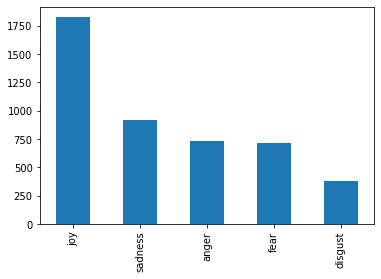

In [7]:
from matplotlib import pyplot
df_tales['target_emotions'].value_counts().plot(kind='bar')

In [8]:
possible_labels = df_tales.target_emotions.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'anger': 0, 'disgust': 4, 'fear': 2, 'joy': 1, 'sadness': 3}

In [9]:
df_tales['label'] = df_tales.target_emotions.replace(label_dict)
df_tales.head()

,text,target_emotions,label
200697,"Listen to the story of Jemima Puddle-duck, who was annoyed because the farmer's wife would not let her hatch her own eggs.",anger,0
200698,"Her sister-in-law, Mrs. Rebeccah Puddle-duck, was perfectly willing to leave the hatching to someone else-- ""I have not the patience to sit on a nest for twenty-eight days; and no more have you, Jemima.",anger,0
200699,"You would let them go cold; you know you would!""",anger,0
200700,"""I wish to hatch my own eggs; I will hatch them all by myself,"" quacked Jemima Puddle-duck.",anger,0
200712,She rather fancied a tree stump amongst some tall foxgloves.,joy,1


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_tales.index.values, 
                                                  df_tales.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df_tales.label.values)
df_tales['data_type'] = ['not_set']*df_tales.shape[0]

df_tales.loc[X_train, 'data_type'] = 'train'
df_tales.loc[X_val, 'data_type'] = 'val'
df_tales.groupby(['target_emotions', 'label', 'data_type']).count()

text
target_emotions label data_type      
anger           0     train       622
                      val         110
disgust         4     train       321
                      val          57
fear            2     train       605
                      val         107
joy             1     train      1553
                      val         274
sadness         3     train       783
                      val         138

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [12]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_tales[df_tales.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_tales[df_tales.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_tales[df_tales.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_tales[df_tales.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [14]:
len(dataset_train), len(dataset_val)

(3884, 686)

In [15]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [18]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [19]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [20]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [22]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_tales_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')



Epoch 1
Training loss: 1.0848864036694916
Validation loss: 0.9528113546899182
F1 Score (Weighted): 0.6422101470669599



Epoch 2
Training loss: 0.6870582083358814
Validation loss: 1.0150305428054167
F1 Score (Weighted): 0.6979603524599128


In [23]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_tales_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [26]:
accuracy_per_class(predictions, true_vals)

Class: anger
Accuracy: 70/110

Class: joy
Accuracy: 192/274

Class: fear
Accuracy: 57/107

Class: sadness
Accuracy: 114/138

Class: disgust
Accuracy: 10/57



In [24]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/emotion_data/finetuned_BERT_tales_epoch_2.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [26]:
accuracy_per_class(predictions, true_vals)

Class: anger
Accuracy: 63/110

Class: joy
Accuracy: 239/274

Class: fear
Accuracy: 60/107

Class: sadness
Accuracy: 106/138

Class: disgust
Accuracy: 17/57



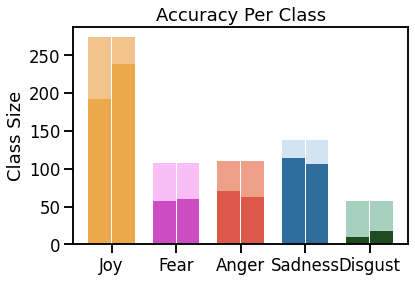

In [105]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

emotion_labels = ['Joy', 'Fear', 'Anger', 'Sadness', 'Disgust']

total_1 = [274, 107, 110, 138, 57]

score_1 = [192, 57, 70, 114, 10]
error_1 = []
for score_i, total_i in zip(score_1, total_1):
    error_1.append(total_i-score_i)

total_2 = [274, 107, 110, 138, 57]

score_2 = [239, 60, 63, 106, 17]
error_2 = []
for score_i, total_i in zip(score_2, total_2):
    error_2.append(total_i-score_i)

score_color = ['#EBA94B', '#CC4CC3', '#DC5849', '#2E6E9C', '#204B20']
error_color = ['#F2C38B', '#F9BEF6', '#ECA088', '#D2E4F2', '#A6D1C0']

x = np.arange(len(emotion_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/1.9, score_1, width, color=score_color)
rects3 = ax.bar(x - width/1.9, error_1, width, bottom=score_1, color=error_color)
rects2 = ax.bar(x + width/1.9, score_2, width, color=score_color)
rects4 = ax.bar(x + width/1.9, error_2, width, bottom=score_2, color=error_color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Class Size')
ax.set_title('Accuracy Per Class')

ax.set_xticks(x)
ax.set_xticklabels(emotion_labels)

plt.show()